In [2]:
import pickle as pkl
import pandas as pd
from mplsoccer import FontManager
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import cm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from highlight_text import fig_text, ax_text
import numpy as np

from mplsoccer import Pitch

from PIL import Image
import urllib
import os

import warnings
warnings.filterwarnings('ignore')

In [3]:
with open('D:\Futbol\Analisis presion alata en PL 23-24\pkl\df_tackle_stats.pkl', 'rb') as archivo:
    df_tackle_stats = pkl.load(archivo)

In [4]:
new_data = []
for idx, row in df_tackle_stats.iterrows():
    for zone, tackles, won in zip(['Defensive-third', 'Middle-third', 'Attacking-third'],
                                         ['tackle_def3rd', 'tackle_mid3rd', 'tackle_att3rd'],
                                         ['tackle_won_def3rd', 'tackle_won_mid3rd', 'tackle_won_att3rd']):
        new_data.append({
            'team_name': row['Equipo'],
            'team_id': row['teamId'],
            'pass_area': zone,
            'tackle': row['tackle'],
            'tackle_area_won': row[won],
            'tackle_won_rate': row['tackle_won'] / row['tackle'],
            'tackle_area_rate': row[tackles] / row['tackle']  if row[tackles] != 0 else 0,
            'tackle_area_won_rate': row[won] / row[tackles] if row[tackles] != 0 else 0})

df_tackle = pd.DataFrame(new_data)

In [5]:
URL1 = 'https://github.com/googlefonts/robotoslab/blob/main/fonts/ttf/RobotoSlab-Light.ttf?raw=true'
robotoslab_light = FontManager(URL1)
URL2 = 'https://github.com/googlefonts/robotoslab/blob/main/fonts/ttf/RobotoSlab-Regular.ttf?raw=true'
robotoslab_regular = FontManager(URL2)
URL3 = 'https://github.com/googlefonts/robotoslab/blob/main/fonts/ttf/RobotoSlab-Bold.ttf?raw=true'
robotoslab_bold = FontManager(URL3)

In [6]:
gradient = [
    '#bababa',
    '#b1b5b9',
    '#a8afb8',
    '#9faab7',
    '#97a5b6',
    '#8ea0b5',
    '#859ab4',
    '#7c95b3',
    '#7390b2',
    '#6a8ab1',
    '#6185b0',
    '#5980b0',
    '#507baf',
    '#4775ae',
    '#3e70ad',
    '#356bac',
    '#2c65ab',
    '#2360aa',
    '#1b5ba9',
    '#1256a8',
    '#0950a7',
    '#004ba6'
]
soc_cm = mcolors.LinearSegmentedColormap.from_list('SOC', gradient, N=50)
cm.register_cmap(name='SOC', cmap=soc_cm)
norm = mcolors.Normalize(vmin=df_tackle['tackle_area_rate'].min(), vmax=df_tackle['tackle_area_rate'].max())

## Tackles

In [20]:
background_color = '#D4D4D4'
font_color = 'black'
img_path = 'D:\Futbol\Analisis presion alata en PL 23-24\img\escudos PL'

In [21]:
def plot_tackle_dist(df:pd.DataFrame ,team_name:str, img_path:str, font_color:str, background_color:str):
    # Parámetros
    team_id = df[df['team_name'] == team_name]['team_id'].max()

    # Crear una figura con tamaño 4x4 pulgadas, una resolución de 300 dpi, y un color de fondo específico
    fig = plt.figure(figsize=(4, 4), dpi=300, facecolor=background_color)
    ax = plt.subplot(111)

    # Cambiar el color de fondo del eje principal para que coincida con el de la figura
    ax.set_facecolor(background_color)

    # Crear y dibujar el campo de fútbol utilizando mplsoccer's Pitch
    pitch = Pitch(pitch_type='opta',
                goal_type='box',
                linewidth=.85,
                line_color='black',
                half=False,
                pitch_color=background_color)  # Especificar el color de fondo del campo
    pitch.draw(ax=ax)

    # Filtrar los datos para el equipo específico con team_id y reiniciar el índice
    aux_data = df[df['team_id'] == team_id].reset_index(drop=True)

    # Definir las divisiones del campo para las áreas de tackle
    pitch_divisions = [0, 100 / 3, 2 * (100 / 3), 100]
    for index, x in enumerate(pitch_divisions[:-1]):
        # Rellenar las áreas del campo con colores según la tasa de tackle
        ax.fill_between(
            x=[pitch_divisions[index], pitch_divisions[index + 1]],
            y1=0, y2=100,
            color=soc_cm(norm(aux_data['tackle_area_rate'].iloc[index])),
            zorder=-1, alpha=0.75
        )
        # Añadir anotaciones con la tasa de tackle en el centro de cada área
        mid_point = pitch_divisions[index] + (100 / 3) / 2
        ax.annotate(
            xy=(mid_point, 103),
            text=f'{aux_data["tackle_area_rate"].iloc[index]:.1%}',
            annotation_clip=False, ha='center', weight='bold',
            size=11, color=font_color, fontproperties=robotoslab_regular.prop
        )
        # Añadir anotaciones con la tasa de éxito de tackle en el borde de cada área
        ax.annotate(
            xy=(pitch_divisions[index + 1] - 2, 103),
            text=f'succ: \n{aux_data["tackle_area_won_rate"].iloc[index]:.1%}',
            annotation_clip=False, ha='right',
            size=5, weight='bold', color='#368f8b', fontproperties=robotoslab_bold.prop
        )

    # Añadir nombre del equipo en la parte superior del gráfico
    team_name_annotation = ax.annotate(
        xy=(50, 125),
        text=f'{aux_data["team_name"].iloc[0].upper()}',
        size=13,
        color=font_color,
        ha='center',
        va='center',
        weight='bold',
        annotation_clip=False,
        fontproperties=robotoslab_bold.prop
    )

    # Añadir tasa de éxito de tackle debajo del nombre del equipo
    ax.annotate(
        xy=(50, 116),
        text=f'Overall tackle success rate: {aux_data["tackle_won_rate"].max():.1%}',
        size=6,
        color=font_color,
        ha='center',
        va='center',
        annotation_clip=False,
        fontproperties=robotoslab_regular.prop
    )

    # Anotaciones de las partes del campo en la parte inferior
    ax.annotate(
        xy=(16.67, -5),
        text='Defensive-Third',
        size=6,
        color=font_color,
        ha='center',
        va='center',
        annotation_clip=False,
        fontproperties=robotoslab_regular.prop
    )
    ax.annotate(
        xy=(50, -5),
        text='Middle-Third',
        size=6,
        color=font_color,
        ha='center',
        va='center',
        annotation_clip=False,
        fontproperties=robotoslab_regular.prop
    )
    ax.annotate(
        xy=(83.33, -5),
        text='Attacking-Third',
        size=6,
        color=font_color,
        ha='center',
        va='center',
        annotation_clip=False,
        fontproperties=robotoslab_regular.prop
    )

    # Funciones para transformar las coordenadas
    DC_to_FC = ax.transData.transform  # Transforma las coordenadas de datos a coordenadas de figura
    FC_to_NFC = fig.transFigure.inverted().transform  # Transforma las coordenadas de figura a coordenadas normalizadas de figura
    DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))  # Función lambda para encadenar ambas transformaciones

    # Ruta de la imagen del escudo del equipo
    full_img_path = img_path + '\{team}.png'.format(team=aux_data['team_name'][0])

    try:
        # Cargar la imagen del escudo del equipo y redimensionarla
        logo = Image.open(full_img_path)
        desired_size = (1000, 1000)  # Tamaño deseado para las imágenes redimensionadas
        logo = logo.resize(desired_size, Image.Resampling.LANCZOS)

        # Convertir la imagen redimensionada de PIL a un array de matplotlib
        logo = np.array(logo)

        # Obtener las coordenadas transformadas para colocar la imagen
        team_name_bbox = team_name_annotation.get_window_extent(renderer=fig.canvas.get_renderer())
        coord = DC_to_NFC((50, 125))  # Coordenadas transformadas

        # Crear un subeje para la imagen del escudo utilizando las coordenadas transformadas
        ax_logo = fig.add_axes([coord[0] - 0.39, coord[1] - 0.265, 0.14, 0.14], anchor='C', zorder=1)

        # Mostrar la imagen en el subeje
        ax_logo.imshow(logo)

        # Ocultar los ejes del subeje para que solo se vea la imagen
        ax_logo.axis('off')
    except FileNotFoundError:
        # Manejar el error si la imagen no se encuentra en la ruta especificada
        print(f'No se encontró la imagen en la ruta especificada: {full_img_path}')

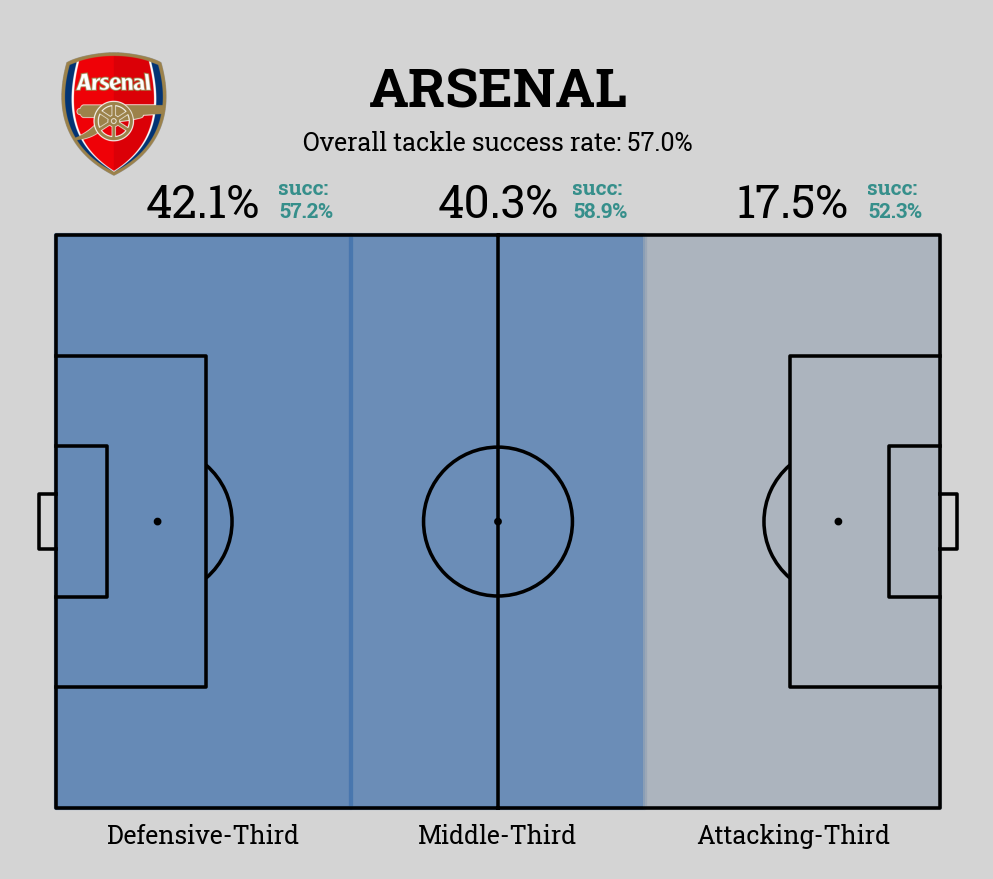

In [22]:
plot_tackle_dist(df_tackle, "Arsenal", img_path, font_color, background_color)

In [10]:
def plot_tackle_dist(ax:object, df:pd.DataFrame, team_name:str, font_color:str, background_color:str):
    # Parámetros
    team_id = df[df['team_name'] == team_name]['team_id'].max()
    
    # Cambiar el color de fondo del eje principal para que coincida con el de la figura
    ax.set_facecolor(background_color)

    # Crear y dibujar el campo de fútbol utilizando mplsoccer's Pitch
    pitch = Pitch(pitch_type='opta',
                goal_type='box',
                linewidth=.85,
                line_color='black',
                half=False,
                pitch_color=background_color)  # Especificar el color de fondo del campo
    pitch.draw(ax=ax)

    # Filtrar los datos para el equipo específico con team_id y reiniciar el índice
    aux_data = df[df['team_id'] == team_id].reset_index(drop=True)

    # Definir las divisiones del campo para las áreas de tackle
    pitch_divisions = [0, 100 / 3, 2 * (100 / 3), 100]
    for index, x in enumerate(pitch_divisions[:-1]):
        # Rellenar las áreas del campo con colores según la tasa de tackle
        ax.fill_between(
            x=[pitch_divisions[index], pitch_divisions[index + 1]],
            y1=0, y2=100,
            color=soc_cm(norm(aux_data['tackle_area_rate'].iloc[index])),
            zorder=-1, alpha=0.75
        )
        # Añadir anotaciones con la tasa de tackle en el centro de cada área
        mid_point = pitch_divisions[index] + (100 / 3) / 2
        ax.annotate(
            xy=(mid_point, 103),
            text=f'{aux_data["tackle_area_rate"].iloc[index]:.1%}',
            annotation_clip=False, ha='center', weight='bold',
            size=11, color=font_color, fontproperties=robotoslab_regular.prop
        )
        # Añadir anotaciones con la tasa de éxito de tackle en el borde de cada área
        ax.annotate(
            xy=(mid_point, 90),
            text=f'succ: {aux_data["tackle_area_won_rate"].iloc[index]:.1%}',
            annotation_clip=False, ha='center',
            size=8, weight='bold', color='#368f8b', fontproperties=robotoslab_bold.prop,
            bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='black', lw=1, alpha=0.75)
        )

    # Añadir nombre del equipo en la parte superior del gráfico
    team_name_annotation = ax.annotate(
        xy=(50, 125),
        text=f'{aux_data["team_name"].iloc[0].upper()}',
        size=13,
        color=font_color,
        ha='center',
        va='center',
        weight='bold',
        annotation_clip=False,
        fontproperties=robotoslab_bold.prop
    )

    # Añadir tasa de éxito de tackle debajo del nombre del equipo
    ax.annotate(
        xy=(50, 116),
        text=f'Overall tackle success rate: {aux_data["tackle_won_rate"].max():.1%}',
        size=8,
        color=font_color,
        ha='center',
        va='center',
        annotation_clip=False,
        fontproperties=robotoslab_regular.prop
    )
    
    return ax

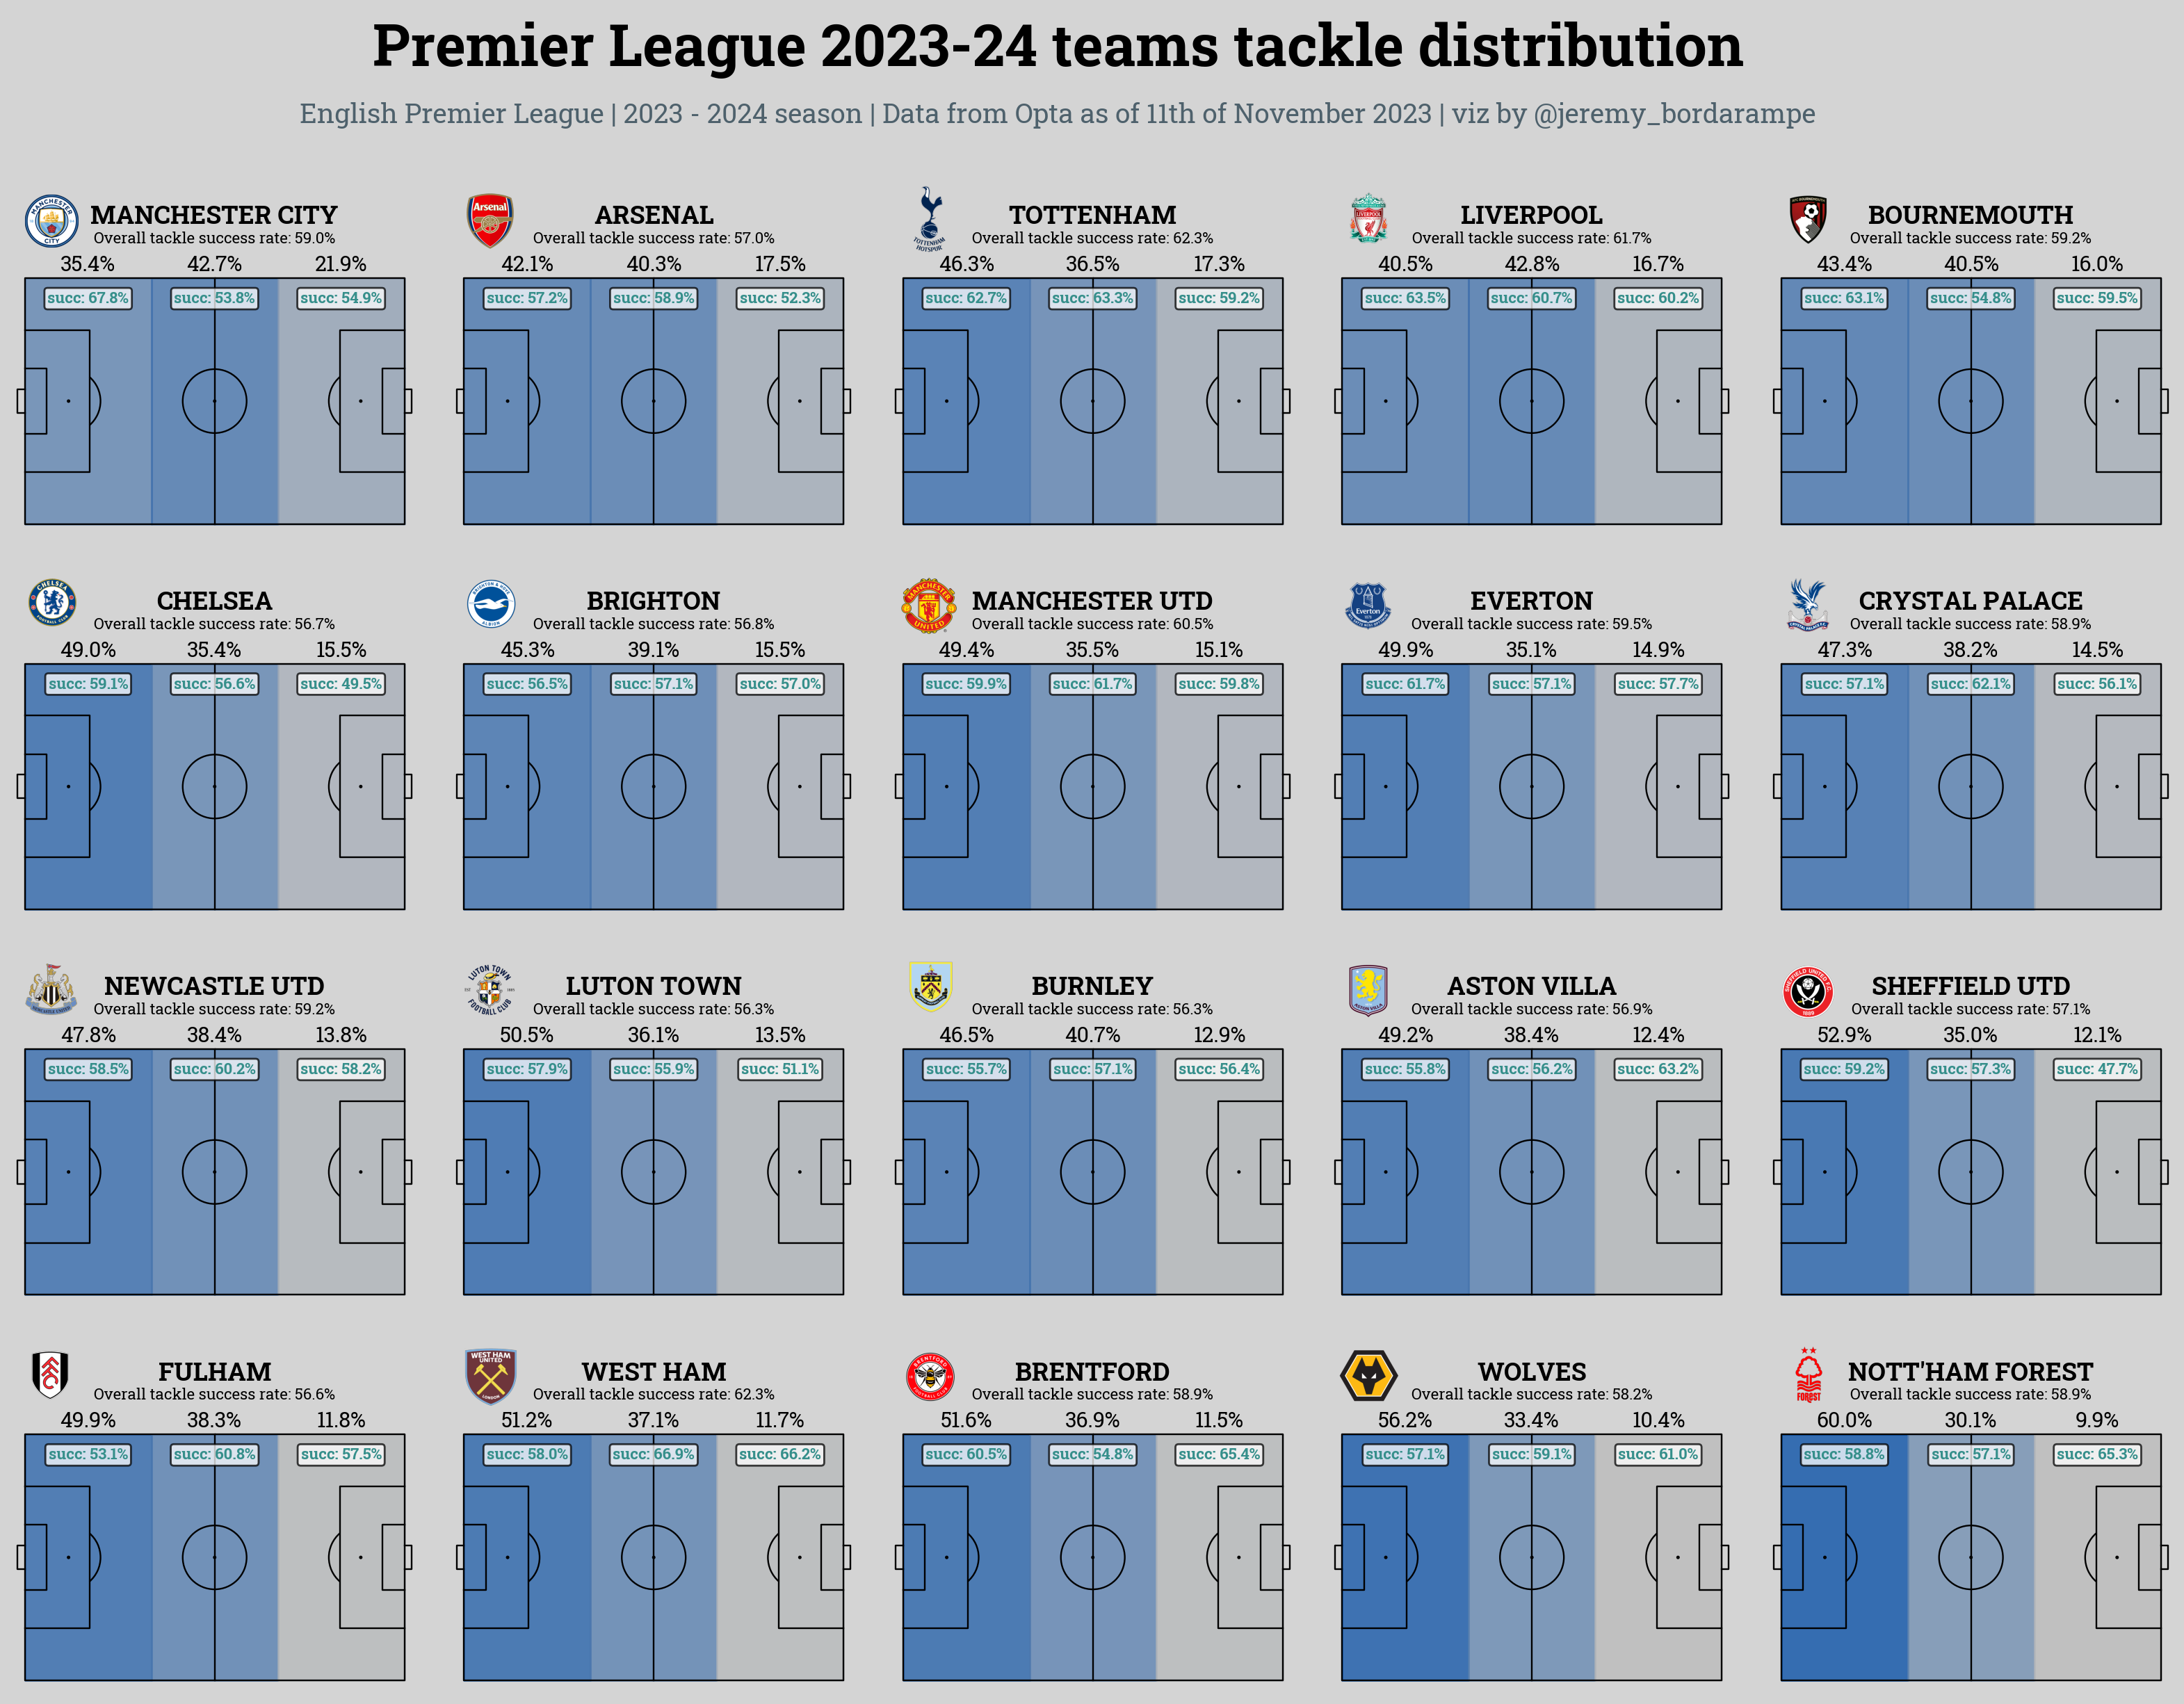

In [13]:
order_teams = df_tackle[df_tackle['pass_area'] == 'Attacking-third'].sort_values(by = 'tackle_area_rate', ascending=False)

fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(20,18), dpi=200, facecolor = background_color)
axs = np.array(axs)

for index, ax in enumerate(axs.reshape(-1)):
    plot_tackle_dist(ax, df_tackle, order_teams['team_name'].iloc[index], font_color, background_color)
    
plt.subplots_adjust(wspace=.1, hspace=-.5)

desired_size = (1000, 1000)  # Tamaño deseado para las imágenes redimensionadas

for index, ax in enumerate(axs.reshape(-1)):
    DC_to_FC = ax.transData.transform
    FC_to_NFC = fig.transFigure.inverted().transform
    DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
    
    ax_coords = DC_to_NFC((-4,70))
    ax_size = 0.03
    image_ax = fig.add_axes([ax_coords[0], ax_coords[1], ax_size, ax_size], fc='None')
    club_icon = Image.open(img_path + '\{team}.png'.format(team=order_teams['team_name'].iloc[index])) #.convert('LA')
    club_icon = club_icon.resize(desired_size, Image.Resampling.LANCZOS)
    image_ax.imshow(club_icon)
    image_ax.axis('off')
    
fig_text(x=0.5, y=.855,
         s='Premier League 2023-24 teams tackle distribution',
         va='bottom', ha='center',
         fontsize=30, color='black',
         font=robotoslab_bold.prop)

fig_text(x = 0.5, y = .835,
         s = 'English Premier League | 2023 - 2024 season | Data from Opta as of 11th of November 2023 | viz by @jeremy_bordarampe',
	     va = 'bottom', ha = 'center',
	     fontsize = 14, color = '#4E616C',
         font=robotoslab_regular.prop, textalign='center')

## Intercepciones

In [14]:
with open('D:\Futbol\Analisis presion alata en PL 23-24\pkl\df_int_stats.pkl', 'rb') as archivo:
    df_int_stats = pkl.load(archivo)

In [17]:
new_data = []
for idx, row in df_int_stats.iterrows():
    for zone, ints, won in zip(['Defensive-third', 'Middle-third', 'Attacking-third'],
                                         ['int_def3rd', 'int_mid3rd', 'int_att3rd'],
                                         ['int_won_def3rd', 'int_won_mid3rd', 'int_won_att3rd']):
        new_data.append({
            'team_name': row['Equipo'],
            'team_id': row['teamId'],
            'pass_area': zone,
            'int': row['int'],
            'int_area_won': row[won],
            'int_area_rate': row[ints] / row['int']  if row[ints] != 0 else 0})

df_int = pd.DataFrame(new_data)

In [27]:
def plot_int_dist(df:pd.DataFrame ,team_name:str, img_path:str, font_color:str, background_color:str):
    # Parámetros
    team_id = df[df['team_name'] == team_name]['team_id'].max()

    # Crear una figura con tamaño 4x4 pulgadas, una resolución de 300 dpi, y un color de fondo específico
    fig = plt.figure(figsize=(4, 4), dpi=300, facecolor=background_color)
    ax = plt.subplot(111)

    # Cambiar el color de fondo del eje principal para que coincida con el de la figura
    ax.set_facecolor(background_color)

    # Crear y dibujar el campo de fútbol utilizando mplsoccer's Pitch
    pitch = Pitch(pitch_type='opta',
                goal_type='box',
                linewidth=.85,
                line_color='black',
                half=False,
                pitch_color=background_color)  # Especificar el color de fondo del campo
    pitch.draw(ax=ax)

    # Filtrar los datos para el equipo específico con team_id y reiniciar el índice
    aux_data = df[df['team_id'] == team_id].reset_index(drop=True)

    # Definir las divisiones del campo para las áreas de int
    pitch_divisions = [0, 100 / 3, 2 * (100 / 3), 100]
    for index, x in enumerate(pitch_divisions[:-1]):
        # Rellenar las áreas del campo con colores según la tasa de int
        ax.fill_between(
            x=[pitch_divisions[index], pitch_divisions[index + 1]],
            y1=0, y2=100,
            color=soc_cm(norm(aux_data['int_area_rate'].iloc[index])),
            zorder=-1, alpha=0.75
        )
        # Añadir anotaciones con la tasa de int en el centro de cada área
        mid_point = pitch_divisions[index] + (100 / 3) / 2
        ax.annotate(
            xy=(mid_point, 103),
            text=f'{aux_data["int_area_rate"].iloc[index]:.1%}',
            annotation_clip=False, ha='center', weight='bold',
            size=11, color=font_color, fontproperties=robotoslab_regular.prop
        )

    # Añadir nombre del equipo en la parte superior del gráfico
    team_name_annotation = ax.annotate(
        xy=(50, 125),
        text=f'{aux_data["team_name"].iloc[0].upper()}',
        size=13,
        color=font_color,
        ha='center',
        va='center',
        weight='bold',
        annotation_clip=False,
        fontproperties=robotoslab_bold.prop
    )

    # Añadir tasa de éxito de int debajo del nombre del equipo
    ax.annotate(
        xy=(50, 116),
        text=f'Total interceptions: {aux_data["int"].max()}',
        size=6,
        color=font_color,
        ha='center',
        va='center',
        annotation_clip=False,
        fontproperties=robotoslab_regular.prop
    )

    # Anotaciones de las partes del campo en la parte inferior
    ax.annotate(
        xy=(16.67, -5),
        text='Defensive-Third',
        size=6,
        color=font_color,
        ha='center',
        va='center',
        annotation_clip=False,
        fontproperties=robotoslab_regular.prop
    )
    ax.annotate(
        xy=(50, -5),
        text='Middle-Third',
        size=6,
        color=font_color,
        ha='center',
        va='center',
        annotation_clip=False,
        fontproperties=robotoslab_regular.prop
    )
    ax.annotate(
        xy=(83.33, -5),
        text='Attacking-Third',
        size=6,
        color=font_color,
        ha='center',
        va='center',
        annotation_clip=False,
        fontproperties=robotoslab_regular.prop
    )

    # Funciones para transformar las coordenadas
    DC_to_FC = ax.transData.transform  # Transforma las coordenadas de datos a coordenadas de figura
    FC_to_NFC = fig.transFigure.inverted().transform  # Transforma las coordenadas de figura a coordenadas normalizadas de figura
    DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))  # Función lambda para encadenar ambas transformaciones

    # Ruta de la imagen del escudo del equipo
    full_img_path = img_path + '\{team}.png'.format(team=aux_data['team_name'][0])

    try:
        # Cargar la imagen del escudo del equipo y redimensionarla
        logo = Image.open(full_img_path)
        desired_size = (1000, 1000)  # Tamaño deseado para las imágenes redimensionadas
        logo = logo.resize(desired_size, Image.Resampling.LANCZOS)

        # Convertir la imagen redimensionada de PIL a un array de matplotlib
        logo = np.array(logo)

        # Obtener las coordenadas transformadas para colocar la imagen
        team_name_bbox = team_name_annotation.get_window_extent(renderer=fig.canvas.get_renderer())
        coord = DC_to_NFC((50, 125))  # Coordenadas transformadas

        # Crear un subeje para la imagen del escudo utilizando las coordenadas transformadas
        ax_logo = fig.add_axes([coord[0] - 0.39, coord[1] - 0.265, 0.14, 0.14], anchor='C', zorder=1)

        # Mostrar la imagen en el subeje
        ax_logo.imshow(logo)

        # Ocultar los ejes del subeje para que solo se vea la imagen
        ax_logo.axis('off')
    except FileNotFoundError:
        # Manejar el error si la imagen no se encuentra en la ruta especificada
        print(f'No se encontró la imagen en la ruta especificada: {full_img_path}')

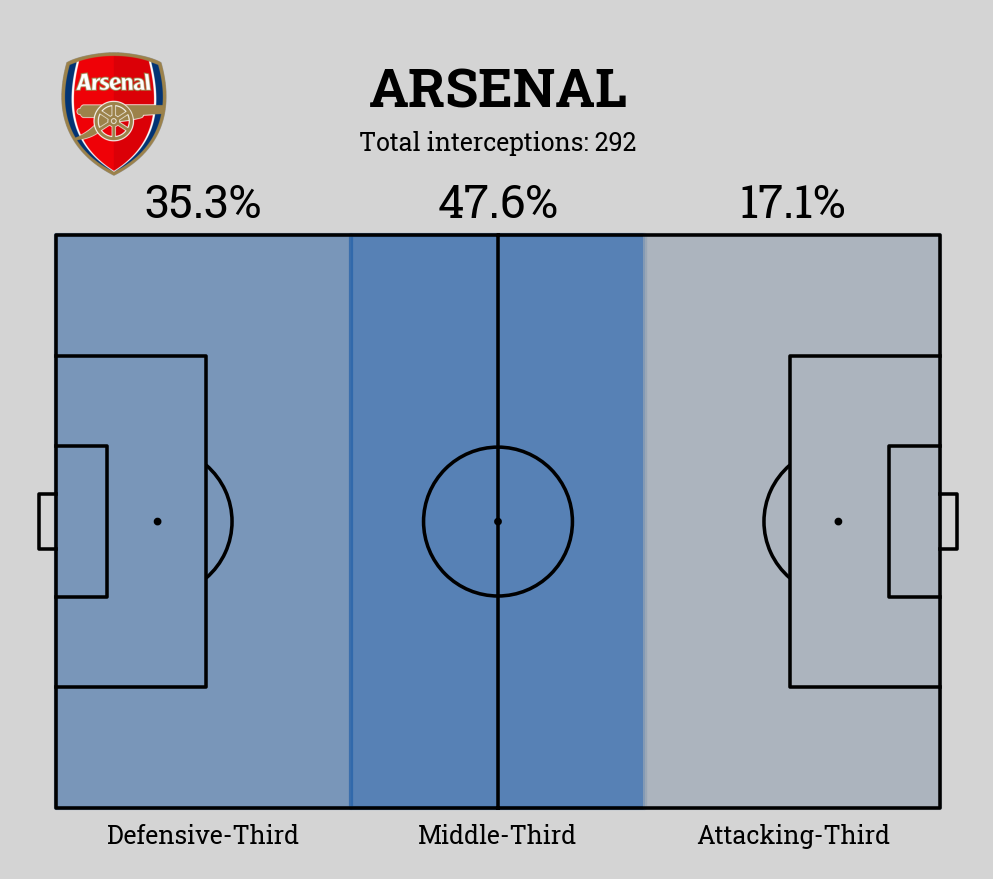

In [28]:
plot_int_dist(df_int, 'Arsenal', img_path, font_color, background_color)

In [30]:
def plot_int_dist(ax:object, df:pd.DataFrame, team_name:str, font_color:str, background_color:str):
    # Parámetros
    team_id = df[df['team_name'] == team_name]['team_id'].max()
    
    # Cambiar el color de fondo del eje principal para que coincida con el de la figura
    ax.set_facecolor(background_color)

    # Crear y dibujar el campo de fútbol utilizando mplsoccer's Pitch
    pitch = Pitch(pitch_type='opta',
                goal_type='box',
                linewidth=.85,
                line_color='black',
                half=False,
                pitch_color=background_color)  # Especificar el color de fondo del campo
    pitch.draw(ax=ax)

    # Filtrar los datos para el equipo específico con team_id y reiniciar el índice
    aux_data = df[df['team_id'] == team_id].reset_index(drop=True)

    # Definir las divisiones del campo para las áreas de int
    pitch_divisions = [0, 100 / 3, 2 * (100 / 3), 100]
    for index, x in enumerate(pitch_divisions[:-1]):
        # Rellenar las áreas del campo con colores según la tasa de int
        ax.fill_between(
            x=[pitch_divisions[index], pitch_divisions[index + 1]],
            y1=0, y2=100,
            color=soc_cm(norm(aux_data['int_area_rate'].iloc[index])),
            zorder=-1, alpha=0.75
        )
        # Añadir anotaciones con la tasa de int en el centro de cada área
        mid_point = pitch_divisions[index] + (100 / 3) / 2
        ax.annotate(
            xy=(mid_point, 103),
            text=f'{aux_data["int_area_rate"].iloc[index]:.1%}',
            annotation_clip=False, ha='center', weight='bold',
            size=11, color=font_color, fontproperties=robotoslab_regular.prop
        )

    # Añadir nombre del equipo en la parte superior del gráfico
    team_name_annotation = ax.annotate(
        xy=(50, 125),
        text=f'{aux_data["team_name"].iloc[0].upper()}',
        size=13,
        color=font_color,
        ha='center',
        va='center',
        weight='bold',
        annotation_clip=False,
        fontproperties=robotoslab_bold.prop
    )

    # Añadir tasa de éxito de int debajo del nombre del equipo
    ax.annotate(
        xy=(50, 116),
        text=f'Total interceptions: {aux_data["int"].max()}',
        size=8,
        color=font_color,
        ha='center',
        va='center',
        annotation_clip=False,
        fontproperties=robotoslab_regular.prop
    )
    
    return ax

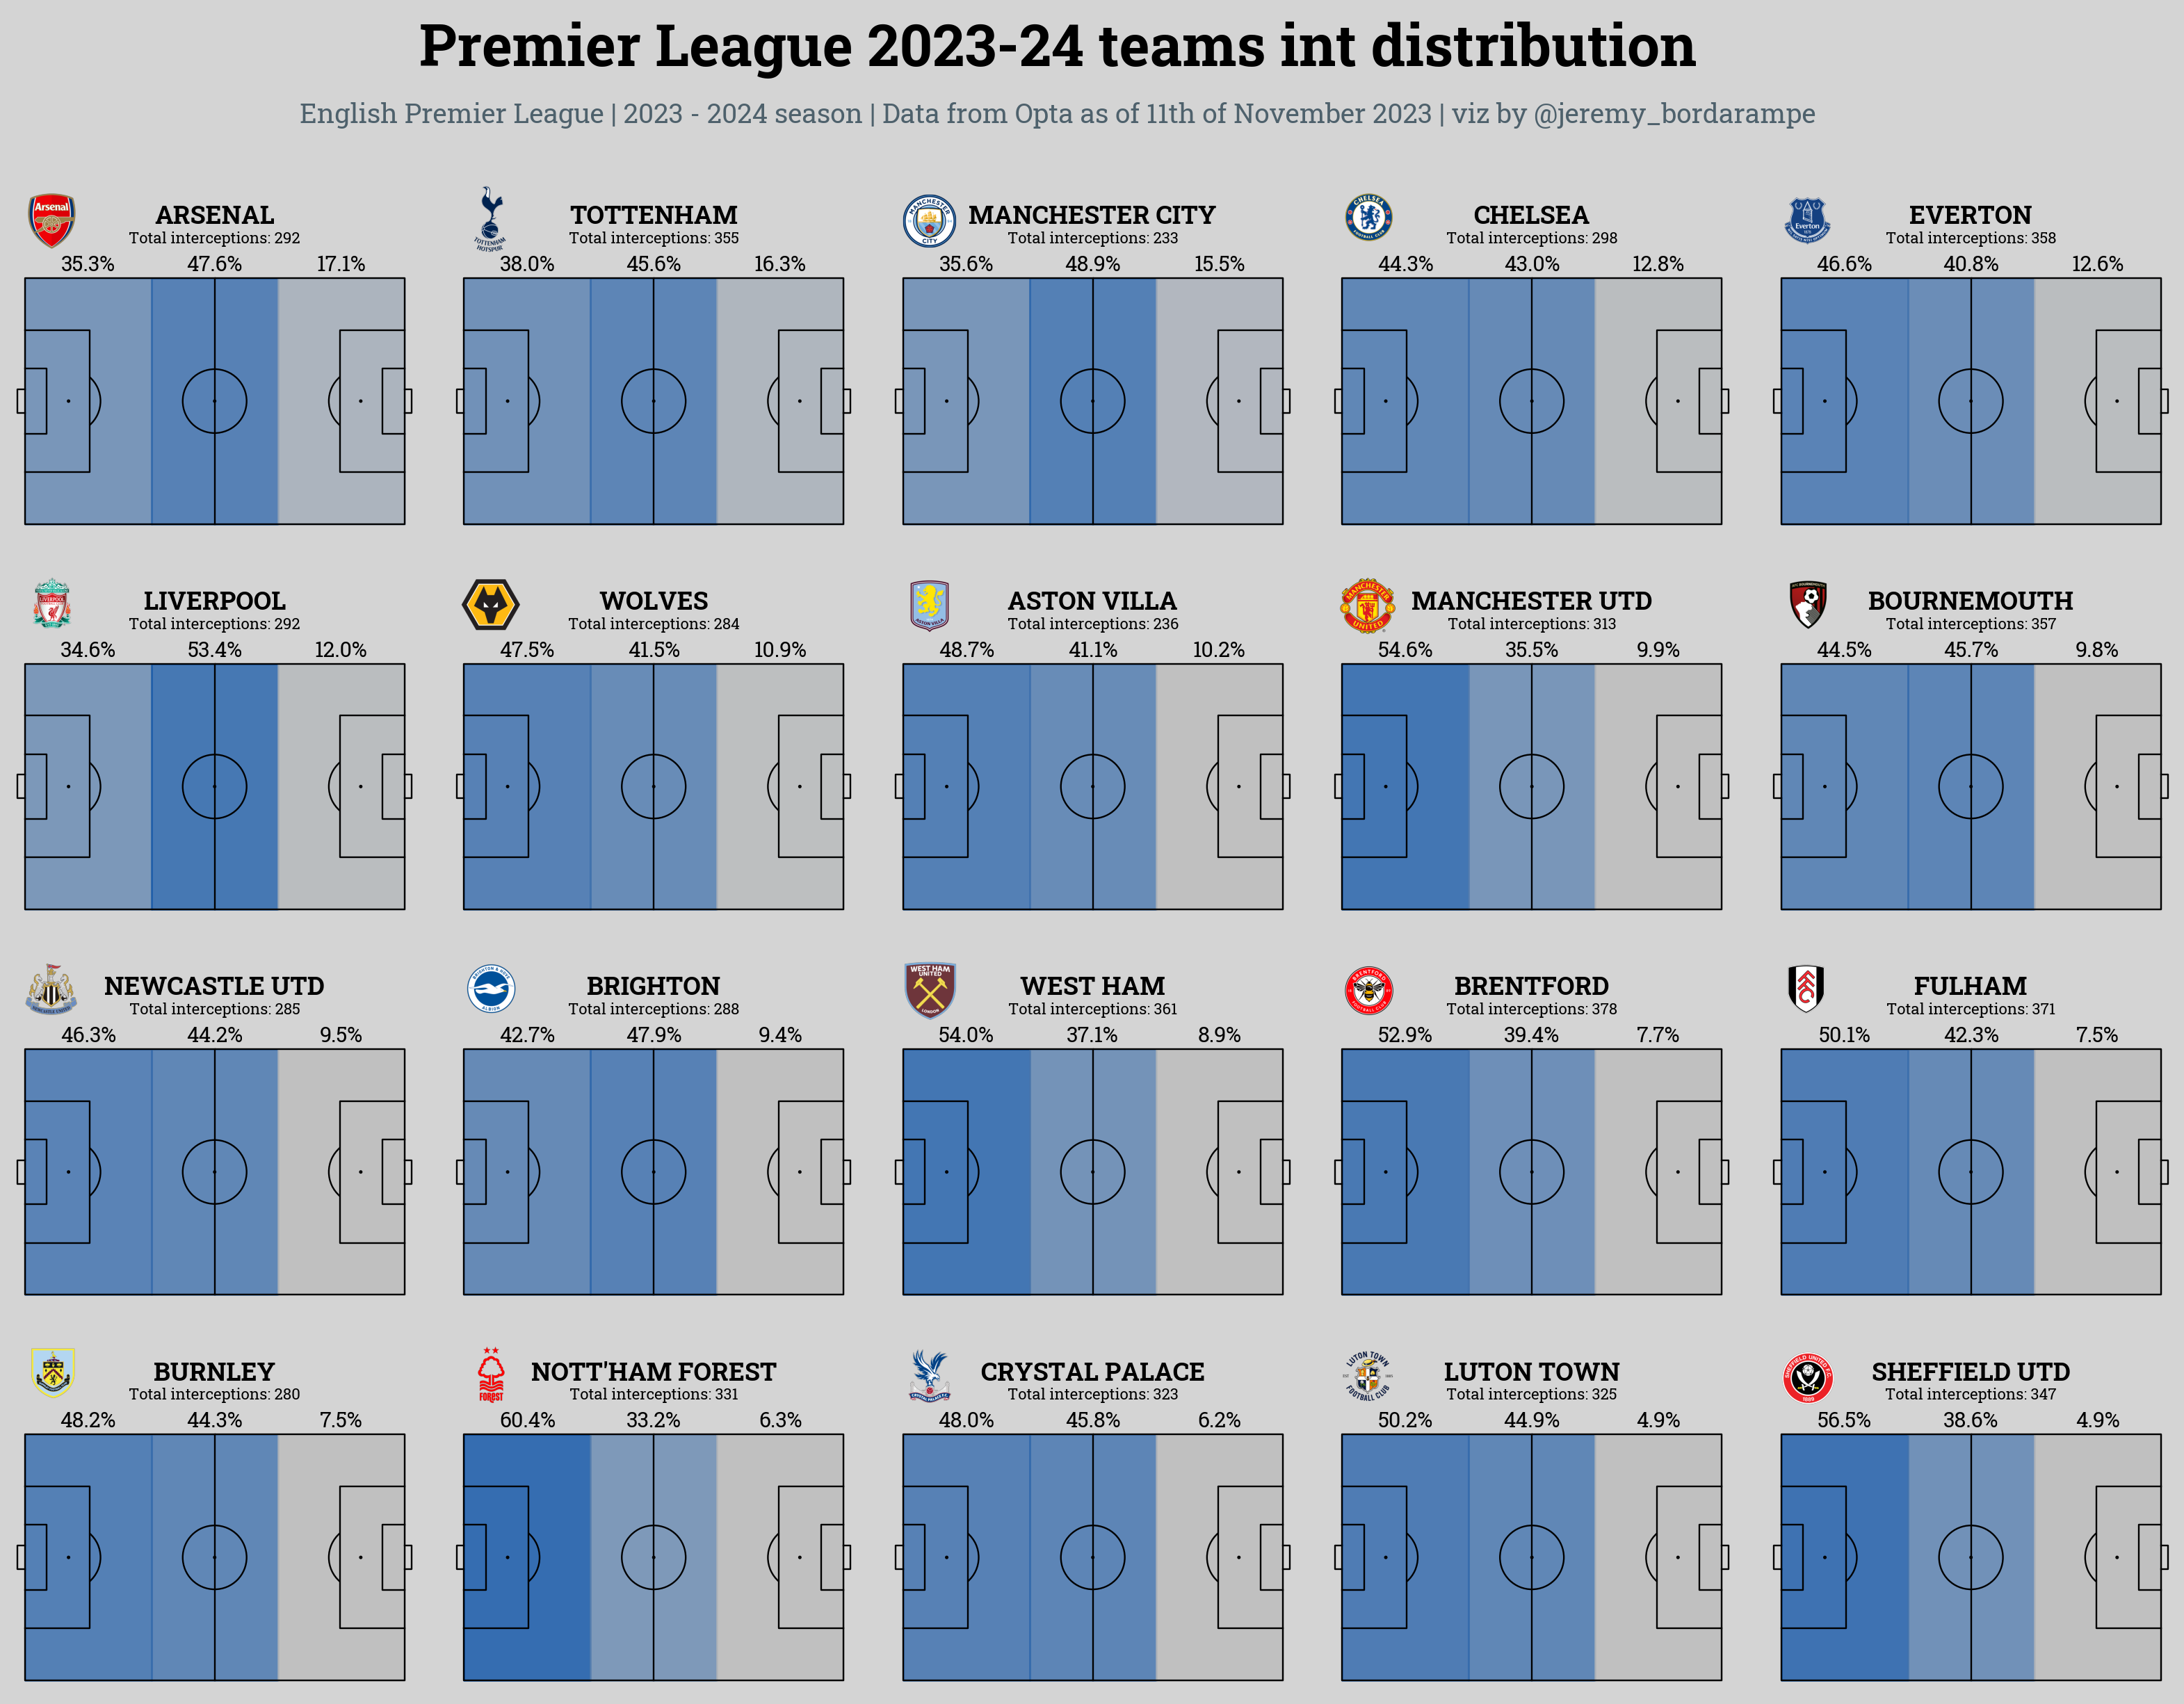

In [31]:
order_teams = df_int[df_int['pass_area'] == 'Attacking-third'].sort_values(by = 'int_area_rate', ascending=False)

fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(20,18), dpi=200, facecolor = background_color)
axs = np.array(axs)

for index, ax in enumerate(axs.reshape(-1)):
    plot_int_dist(ax, df_int, order_teams['team_name'].iloc[index], font_color, background_color)
    
plt.subplots_adjust(wspace=.1, hspace=-.5)

desired_size = (1000, 1000)  # Tamaño deseado para las imágenes redimensionadas

for index, ax in enumerate(axs.reshape(-1)):
    DC_to_FC = ax.transData.transform
    FC_to_NFC = fig.transFigure.inverted().transform
    DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
    
    ax_coords = DC_to_NFC((-4,70))
    ax_size = 0.03
    image_ax = fig.add_axes([ax_coords[0], ax_coords[1], ax_size, ax_size], fc='None')
    club_icon = Image.open(img_path + '\{team}.png'.format(team=order_teams['team_name'].iloc[index])) #.convert('LA')
    club_icon = club_icon.resize(desired_size, Image.Resampling.LANCZOS)
    image_ax.imshow(club_icon)
    image_ax.axis('off')
    
fig_text(x=0.5, y=.855,
         s='Premier League 2023-24 teams interceptions distribution',
         va='bottom', ha='center',
         fontsize=30, color='black',
         font=robotoslab_bold.prop)

fig_text(x = 0.5, y = .835,
         s = 'English Premier League | 2023 - 2024 season | Data from Opta as of 11th of November 2023 | viz by @jeremy_bordarampe',
	     va = 'bottom', ha = 'center',
	     fontsize = 14, color = '#4E616C',
         font=robotoslab_regular.prop, textalign='center')